In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from astropy.time import Time
from astropy.table import Table
from astropy import units as u
from astropy import constants as const
import seaborn as sns
from style import output_folder, big_fontsize, base_width, base_height, dpi
from astropy.cosmology import WMAP9 as cosmo
from astropy.io import fits

In [2]:
plt.rcParams["font.family"] = "Helvetica Neue"
plt.rc('text', usetex=True)
public_folder = "/Users/robertstein/usnik/public_html/public/"

In [3]:
source_name = "BZQJ0253+0006"
source_redshift = 1.0
nu = ("IC211116A", "2021-11-16T10:33:16.05")

In [6]:
def plot_irsa_lightcurve(source_name, source_redshift, nu, plot_mag=False, make_public=False):
    
    redshift = 1. + source_redshift
    
    if plot_mag: 
        dist_mod = 5 * (np.log10(cosmo.luminosity_distance(z=(redshift-1)).to(u.pc).value) - 1.)
    else:
        conversion_factor = 4 * np.pi * cosmo.luminosity_distance(z=(redshift-1)).to(u.cm) **2. / (redshift)
    
    data = fits.open(f"data/{source_name}.fits")

    plt.figure(figsize=(base_width, base_height), dpi=dpi)

    ax = plt.subplot(111)
    ax1b = ax.twinx()

    cmap = {
        "zg": "g",
        "zr": "r",
        "zi": "orange"
    }

    cmap2 = {
        1: "g",
        2: "r",
        3: "orange"
    }

    wl = {
        "zg": 472.27,
        "zr": 633.96,
        "zi": 788.61,
    }

    markersize=2.
    
    latest_index = list(data[1].data['mjd']).index(max(data[1].data['mjd']))
    latest = data[1].data[latest_index]
    print(f" total of {len(data[1].data)} detections")
    print(f"Most recent detection on {latest['MJD']} MJD at a magnitude of {latest['filtercode'][1]}={latest['mag']:.2f}+/-{latest['magerr']:.2f}")

    for fc in ["zg", "zr", "zi"]:
        mask = data[1].data["filtercode"] == fc

        mags = data[1].data["mag"][mask] * u.ABmag
        
        magerrs = (data[1].data["magerr"][mask] + data[1].data["mag"][mask]) * u.ABmag
        
        if plot_mag:
            ax.errorbar(
                data[1].data["mjd"][mask], 
                mags.value,
                yerr=data[1].data["magerr"][mask],
                marker="o",
                linestyle=" ",
                markersize=markersize,
                c=cmap[fc],
                label=f'{fc[-1]} ({wl[fc]:.0f} nm)',
            )
            
            ax1b.errorbar(
                data[1].data["mjd"][mask], 
                mags.value - dist_mod,
                yerr=data[1].data["magerr"][mask],
                marker="o",
                linestyle=" ",
                markersize=markersize,
                c=cmap[fc],
                label=f'{fc[-1]} ({wl[fc]:.0f} nm)',
            )
            
        
        else:

            flux_j = mags.to(u.Jansky)

            f = (const.c/(wl[fc] * u.nm)).to("Hz")

            flux = (flux_j * f).to("erg cm-2 s-1")

            jerrs = magerrs.to(u.Jansky)
            ferrs = (jerrs * f).to("erg cm-2 s-1").value - flux.value

            ax.errorbar(
                data[1].data["mjd"][mask], 
                flux.to("erg cm-2 s-1").value,
                yerr=ferrs,
                marker="o",
                linestyle=" ",
                markersize=markersize,
                c=cmap[fc],
                label=f'{fc[-1]} ({wl[fc]:.0f} nm)',
            )

            l = flux * conversion_factor

            ax1b.errorbar(
                data[1].data["mjd"][mask], 
                l.to("erg s-1"),
                marker="o",
                linestyle=" ",
                markersize=markersize,
                c=cmap[fc],
                label=f'{fc[-1]} ({wl[fc]:.0f} nm)',
            )
            
    if plot_mag:
        ax.set_ylabel(r"Apparent magnitude [AB]", fontsize=big_fontsize)
        ax1b.set_ylabel(fr"Absolute magnitude [AB]", fontsize=big_fontsize)
        
        y_min, y_max = ax.get_ylim()

        ax1b.set_ylim(y_min - dist_mod, y_max - dist_mod)
        
        for a in [ax, ax1b]:
            a.invert_yaxis()
    else:
        ax.set_ylabel(r"$\nu$F$_{\nu}$ [erg cm$^{-2}$ s$^{-1}$]", fontsize=big_fontsize)
        ax1b.set_ylabel(r"$\nu$L$_{\nu}$ [erg s$^{-1}$]", fontsize=big_fontsize)
        
        ax.set_yscale("log")
        ax1b.set_yscale("log")

        y_min, y_max = ax.get_ylim()

        ax1b.set_ylim(y_min * conversion_factor.value, y_max * conversion_factor.value)
        
        
        
    ax.set_xlabel("Date (MJD)", fontsize=big_fontsize)
    
    ax.set_title(f'ZTF Lightcurve of {source_name.replace("J", " J")}', y=1.2)

    # else:
    #     ax.set_ylim(bottom=0.0)
    #     ax1b.set_ylim(bottom=0.0)

    ax.tick_params(axis='both', which='major', labelsize=big_fontsize)
    ax1b.tick_params(axis='both', which='major', labelsize=big_fontsize)

    t_neutrino = Time(nu[1], format='isot', scale='utc')

    ax.axvline(t_neutrino.mjd, linestyle=":", label=nu[0])

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.22),
              ncol=4, fancybox=True, fontsize=big_fontsize)

    filename = f"{source_name}_lightcurve{['_flux',''][plot_mag]}.png"

    output_path = os.path.join(output_folder, f"{filename}")

    plt.savefig(f"plots/{filename}", bbox_inches='tight', pad_inches=0.)
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0.)
    
    if make_public:
        
        public_path = os.path.join(public_folder, f"{filename}")
        plt.savefig(public_path, bbox_inches='tight', pad_inches=0.5)

 total of 78 detections
Most recent detection on 59444.4681944 MJD at a magnitude of r=21.20+/-0.23


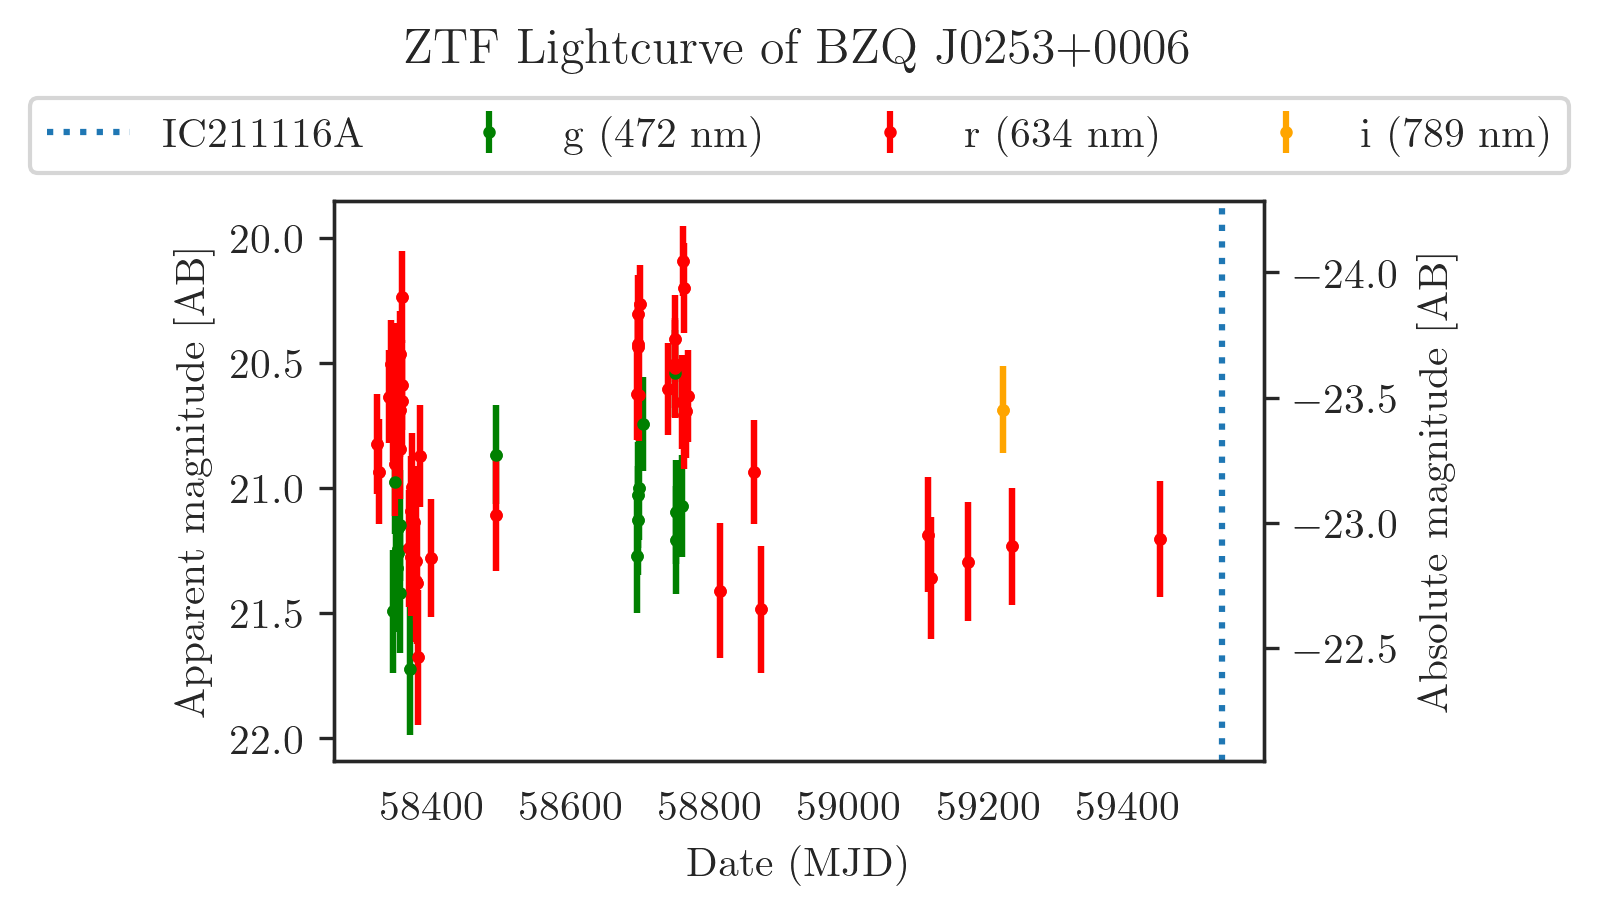

In [7]:
plot_irsa_lightcurve(source_name, source_redshift, nu, plot_mag=True, make_public=True)